<a href="https://colab.research.google.com/github/JASONZ777/senti_analy_prompt-BERT/blob/main/lora_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Method 3： LoRA-tuning

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
import os
os.chdir('/content/gdrive/MyDrive/instruct-caption')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
import csv
dataset = []
with open('nonaccident.csv', newline='') as csvfile:
    # csv reader, divide by $
    csvreader = csv.reader(csvfile, delimiter='$')
    for row in csvreader:
        caption = row[1]
        context = caption + '\t' + '1'
        dataset.append(context)
with open('dataset.txt','a') as file:
    for line in dataset:
        file.write(line+'\n')

In [ ]:
import random

with open('dataset.txt', 'r', encoding='utf-8') as f:
    lines = f.readlines()

total_lines = len(lines)
# index  = list(range(total_lines))
# 计算9:1的分割点
random.shuffle(lines)
split_point = int(total_lines * 0.9)

# 将原始文件按9:1比例分割并写入新文件
with open('train.txt', 'w', encoding='utf-8') as train_file:
    train_file.writelines(lines[:split_point])

with open('val.txt', 'w', encoding='utf-8') as val_file:
    val_file.writelines(lines[split_point:])


In [2]:
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from torch.utils.data import Dataset

class upload_dataset(Dataset):
    def __init__(self, data_file):
        self.data = self.load_data(data_file)

    def load_data(self, data_file):
        Data = {}
        with open(data_file, 'rt', encoding='utf-8') as f:
            for idx, line in enumerate(f):
                items = line.strip().split('\t')
                assert len(items) == 2
                Data[idx] = {
                    'comment': items[0],
                    'label': int(items[1]),
                }
        return Data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [3]:
# testing
train_data = upload_dataset('train.txt')
valid_data = upload_dataset('val.txt')
# test_data = upload_dataset('chnsenticorp/test/part.0')
print(f'train set size: {len(train_data)}')
print(f'valid set size: {len(valid_data)}')
# print(f'test set size: {len(test_data)}')
print(next(iter(train_data)))

train set size: 890
valid set size: 99
{'comment': 'In the image, a black car is seen in the middle of a street, having lost control and veered off the road. The car is now resting on its side, with its wheels in the air. The vehicle appears to have collided with a street lamp, which is now lying on the ground. The scene is set in a parking lot adjacent to a building, with a few other cars parked in the background. The ground is wet, suggesting that it might have rained recently. There', 'label': 0}


In [4]:
def map_label(tokenizer):
    return {
        '1': {'token': 'safe', 'id': tokenizer.convert_tokens_to_ids("safe")},
        '0': {'token': 'dangerous', 'id': tokenizer.convert_tokens_to_ids("dangerous")}
    }

In [5]:
import torch
import numpy as np
import torch.nn as nn
from torch.utils.data import DataLoader
from transformers import AutoTokenizer
# checkpoint = 'bert-base-chinese'
checkpoint = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
# find the id of the label defined in tokenizer
label = map_label(tokenizer)
pos_id, neg_id = label['1']['id'], label['0']['id']
# Dataloader, in NLP we usually use collate_fn to do the padding to make sure samples have the same sequence length
def collate(batch_samples): # operate on each batch
    batch_sentence = []
    batch_label = []
    batch_mask_id = []
    max_length = 0
    for sample in batch_samples:
        batch_sentence.append(sample['comment'])
        encoding = tokenizer(sample['comment'], truncation=True)
        max_length = max(max_length, len(encoding.tokens())) # dynamic padding to the longest
        batch_label.append(sample['label'])
    batch_inputs = tokenizer(batch_sentence, max_length=496, padding=True, truncation=True, return_tensors="pt")
    label_id = [neg_id, pos_id]
    return {
        'batch_inputs':batch_inputs,
        'label_id': label_id,
        'labels': batch_label

    }


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [7]:
!pip install -q peft
!pip install -q evaluate
!pip install bitsandbytes
!pip install -q accelerate


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.1/199.1 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.6/297.6 kB 34.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 30.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 MB 8.7 MB/s eta 0:00:00


## Lora using PEFT

In [8]:
from peft import LoraConfig, TaskType, get_peft_model, PromptTuningConfig, PromptTuningInit
from transformers import BertForSequenceClassification, BitsAndBytesConfig
lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS, r=2, lora_alpha=4, lora_dropout=0.2
)
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

prompt_config = PromptTuningConfig(
    task_type=TaskType.SEQ_CLS,
    prompt_tuning_init=PromptTuningInit.RANDOM,
    num_virtual_tokens=16,
    tokenizer_name_or_path=checkpoint
)
base_model = BertForSequenceClassification.from_pretrained(
    checkpoint,
    use_cache=False,
)

model = get_peft_model(base_model, lora_config)
print(model)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): BertForSequenceClassification(
      (bert): BertModel(
        (embeddings): BertEmbeddings(
          (word_embeddings): Embedding(30522, 768, padding_idx=0)
          (position_embeddings): Embedding(512, 768)
          (token_type_embeddings): Embedding(2, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): BertEncoder(
          (layer): ModuleList(
            (0-11): 12 x BertLayer(
              (attention): BertAttention(
                (self): BertSelfAttention(
                  (query): lora.Linear(
                    (base_layer): Linear(in_features=768, out_features=768, bias=True)
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.2, inplace=False)
                    )
                    (lora_A): ModuleDict(
                      (default): L

In [10]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

print_trainable_parameters(model)

trainable params: 75266 || all params: 109559044 || trainable%: 0.06869902953881196


## Baseline

In [9]:
from transformers import AdamW
from tqdm import tqdm
# Hyper-parameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# put data to GPU
def to_device(batch_data):
    new_batch_data = {}
    for k, v in batch_data.items():
        if k == 'batch_inputs':
            new_batch_data[k] = {
                k_: v_.to(device) for k_, v_ in v.items()
            }
        elif k == 'label_id':
            new_batch_data[k] = v
        else:
            new_batch_data[k] = torch.tensor(v).to(device)
    return new_batch_data

optimizer = AdamW(model.parameters(), lr=2e-4)
loss_fun = torch.nn.CrossEntropyLoss()
num_epoch = 20
batch_size = 8

# encapsulate into the dataloader as input
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=collate)
valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=True, collate_fn=collate)
# test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True, collate_fn=collate)

# logs
loss_hists = {'train':[],'val': []}
acc_hists = {'train':[],'val': []}

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [10]:
val_loss = 0
correct_num = 0
for i, batch_data in enumerate(valid_loader):
    batch_data = to_device(batch_data)
    output = base_model(**batch_data['batch_inputs'])
    output = output.logits
    loss = loss_fun(output, batch_data['labels'])
    output = output.argmax(dim=1)

    correct_num += (output == batch_data['labels']).sum().item()
    val_loss+=loss

acc = correct_num/ (len(valid_loader)*batch_size)
average_val_loss = val_loss/len(valid_loader)
print(f'Validation loss: {average_val_loss:.4f}, Validation accuracy: {acc:.4f}')

Validation loss: 0.7792, Validation accuracy: 0.3173


## Training

Epoch 1/20: 100%|██████████| 112/112 [00:13<00:00,  8.49it/s]


Epoch 1/20, Training Loss: 0.6943, Training accuracy: 0.5223
Epoch 1/20, Validation loss: 0.6601, Validation accuracy: 0.6538


Epoch 2/20: 100%|██████████| 112/112 [00:12<00:00,  9.10it/s]


Epoch 2/20, Training Loss: 0.6577, Training accuracy: 0.5982
Epoch 2/20, Validation loss: 0.6470, Validation accuracy: 0.6635


Epoch 3/20: 100%|██████████| 112/112 [00:12<00:00,  8.82it/s]


Epoch 3/20, Training Loss: 0.5522, Training accuracy: 0.7266
Epoch 3/20, Validation loss: 0.5821, Validation accuracy: 0.7019


Epoch 4/20: 100%|██████████| 112/112 [00:12<00:00,  8.87it/s]


Epoch 4/20, Training Loss: 0.5215, Training accuracy: 0.7400
Epoch 4/20, Validation loss: 0.4958, Validation accuracy: 0.7500


Epoch 5/20: 100%|██████████| 112/112 [00:13<00:00,  8.32it/s]


Epoch 5/20, Training Loss: 0.4955, Training accuracy: 0.7712
Epoch 5/20, Validation loss: 0.5282, Validation accuracy: 0.7308


Epoch 6/20: 100%|██████████| 112/112 [00:12<00:00,  8.73it/s]


Epoch 6/20, Training Loss: 0.4740, Training accuracy: 0.7768
Epoch 6/20, Validation loss: 0.5423, Validation accuracy: 0.7308


Epoch 7/20: 100%|██████████| 112/112 [00:12<00:00,  8.85it/s]


Epoch 7/20, Training Loss: 0.4206, Training accuracy: 0.8025
Epoch 7/20, Validation loss: 0.6483, Validation accuracy: 0.6923


Epoch 8/20: 100%|██████████| 112/112 [00:12<00:00,  8.93it/s]


Epoch 8/20, Training Loss: 0.4145, Training accuracy: 0.8136
Epoch 8/20, Validation loss: 0.6876, Validation accuracy: 0.6731


Epoch 9/20: 100%|██████████| 112/112 [00:12<00:00,  8.73it/s]


Epoch 9/20, Training Loss: 0.3950, Training accuracy: 0.8170
Epoch 9/20, Validation loss: 0.5188, Validation accuracy: 0.7308


Epoch 10/20: 100%|██████████| 112/112 [00:12<00:00,  8.90it/s]


Epoch 10/20, Training Loss: 0.3613, Training accuracy: 0.8382
Epoch 10/20, Validation loss: 0.5096, Validation accuracy: 0.7404


Epoch 11/20: 100%|██████████| 112/112 [00:12<00:00,  8.85it/s]


Epoch 11/20, Training Loss: 0.3434, Training accuracy: 0.8493
Epoch 11/20, Validation loss: 0.4805, Validation accuracy: 0.7596


Epoch 12/20: 100%|██████████| 112/112 [00:12<00:00,  8.82it/s]


Epoch 12/20, Training Loss: 0.3210, Training accuracy: 0.8594
Epoch 12/20, Validation loss: 0.4744, Validation accuracy: 0.7308


Epoch 13/20: 100%|██████████| 112/112 [00:12<00:00,  8.65it/s]


Epoch 13/20, Training Loss: 0.2778, Training accuracy: 0.8906
Epoch 13/20, Validation loss: 0.5301, Validation accuracy: 0.7596


Epoch 14/20: 100%|██████████| 112/112 [00:12<00:00,  8.88it/s]


Epoch 14/20, Training Loss: 0.2755, Training accuracy: 0.8873
Epoch 14/20, Validation loss: 0.5726, Validation accuracy: 0.7308


Epoch 15/20: 100%|██████████| 112/112 [00:12<00:00,  8.88it/s]


Epoch 15/20, Training Loss: 0.2353, Training accuracy: 0.9051
Epoch 15/20, Validation loss: 0.5571, Validation accuracy: 0.7404


Epoch 16/20: 100%|██████████| 112/112 [00:12<00:00,  8.85it/s]


Epoch 16/20, Training Loss: 0.2233, Training accuracy: 0.9085
Epoch 16/20, Validation loss: 0.5770, Validation accuracy: 0.7500


Epoch 17/20: 100%|██████████| 112/112 [00:12<00:00,  8.87it/s]


Epoch 17/20, Training Loss: 0.2007, Training accuracy: 0.9208
Epoch 17/20, Validation loss: 0.6698, Validation accuracy: 0.7404


Epoch 18/20: 100%|██████████| 112/112 [00:12<00:00,  8.86it/s]


Epoch 18/20, Training Loss: 0.1934, Training accuracy: 0.9152
Epoch 18/20, Validation loss: 0.6200, Validation accuracy: 0.7692


Epoch 19/20: 100%|██████████| 112/112 [00:12<00:00,  8.86it/s]


Epoch 19/20, Training Loss: 0.1702, Training accuracy: 0.9375
Epoch 19/20, Validation loss: 0.6294, Validation accuracy: 0.7596


Epoch 20/20: 100%|██████████| 112/112 [00:12<00:00,  8.86it/s]


Epoch 20/20, Training Loss: 0.1790, Training accuracy: 0.9219
Epoch 20/20, Validation loss: 0.6380, Validation accuracy: 0.7500


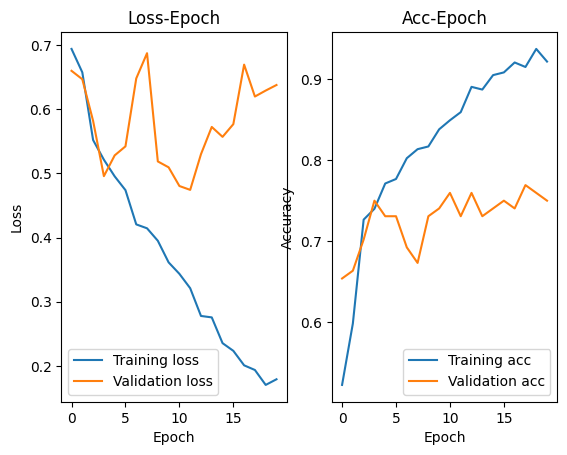

In [13]:
import matplotlib.pyplot as plt
for epoch in range(num_epoch):
  train_loss = 0
  i = 1
  correct_num = 0
  num_batch = 0
  for batch_data in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epoch}"):
    if num_batch < 300:
      model.train() # training mode
      batch_data = to_device(batch_data)
      output = model(**batch_data['batch_inputs'])
      output = output.logits
      loss = loss_fun(output, batch_data['labels'])
      loss.backward()
      train_loss+=loss.item()

      optimizer.step()
      optimizer.zero_grad()# set gradient to 0 when batch is updated


      # if i % 10 == 0: # record every 10 training batches
      #     output = output.argmax(dim=1)
      #     acc = (output == batch_data['labels']).sum().item()/ len(batch_data['labels'])
      #     print(f'Training stage:Batch {i}, Loss: {loss.item()}, Accuracy: {acc}')

      # if i % 30 == 0: # validate every 30 batches
      #     model.eval()
      #     batch_val = next(iter(valid_loader))
      #     with torch.no_grad():
      #         batch_val = to_device(batch_val)
      #         output = model(**batch_val)
      #     val_loss = loss_fun(output, torch.tensor(batch_val['labels']))
      #     output = output.argmax(dim=1)
      #     acc = (output == torch.tensor(batch_val['labels'])).sum().item()/ len(batch_val['labels'])
      #     print(f'Validation stage:Batch {i}, Loss: {loss.item()}, Accuracy: {acc}')

      # i+=1
      num_batch+=1
      output = output.argmax(dim=1)
      correct_num += (output == batch_data['labels']).sum().item()
    else:
      break

  acc = correct_num/(num_batch*batch_size)
  average_loss = train_loss/num_batch
  loss_hists['train'].append(average_loss)
  acc_hists['train'].append(acc)
  print(f"Epoch {epoch + 1}/{num_epoch}, Training Loss: {average_loss:.4f}, Training accuracy: {acc:.4f}")


  # validation
  model.eval()
  with torch.no_grad():
    val_loss = 0
    correct_num = 0
    for i, batch_data in enumerate(valid_loader):
        batch_data = to_device(batch_data)
        output = model(**batch_data['batch_inputs'])
        output = output.logits
        loss = loss_fun(output, batch_data['labels'])
        output = output.argmax(dim=1)

        correct_num += (output == batch_data['labels']).sum().item()
        val_loss+=loss

    acc = correct_num/ (len(valid_loader)*batch_size)
    average_val_loss = val_loss/len(valid_loader)

    loss_hists['val'].append(average_val_loss)
    acc_hists['val'].append(acc)
    print(f'Epoch {epoch + 1}/{num_epoch}, Validation loss: {average_val_loss:.4f}, Validation accuracy: {acc:.4f}')





# draw the loss figures
fig, ax = plt.subplots(1,2)
ax[0].plot(torch.tensor(loss_hists['train']).cpu().detach().numpy()) # can only matplotlib to plot numpy on CPU
ax[0].plot(torch.tensor(loss_hists['val']).cpu().detach().numpy())
ax[0].set_title('Loss-Epoch')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend(['Training loss', 'Validation loss'])

ax[1].plot(torch.tensor(acc_hists['train']).cpu().detach().numpy())
ax[1].plot(torch.tensor(acc_hists['val']).cpu().detach().numpy())
ax[1].set_title('Acc-Epoch')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].legend(['Training acc', 'Validation acc'])
plt.show()